# Predicting Formation Factor

The formation factor is the ratio of the conductivity of the pure brine to the measured conductivity 

$$
F = \frac{\sigma_{brine}}{\sigma_{measured}}\\
$$

This example shows how to calculate the formation factor from a Fickian diffusion simulation on a cubic network. Note that formation factor calculation on an extracted network from Porespy follows similar steps in assigning phase, algorithm and calculating the effective property.

In [1]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt

op.visualization.set_mpl_style()
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

/home/amin/Code/OpenPNM/openpnm/algorithms/_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover


## Create Network

In [2]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()

## Create Phase

Since the formation factor is a property of the porous medium and not the diffusing phase, any phase with known diffusion coefficient can be used as the diffusing phase. In this example, we use water as the phase diffusing through the porous medium. 

In [3]:
phase = op.phase.Water(network=pn)
phase['pore.diffusivity'] = 2.299e-9
phase.add_model_collection(op.models.collections.physics.basic)
phase.regenerate_models()

## Apply Fickian Diffusion

To calculate the formation factor in the x direction, a constant concentration boundary condition is applied on the left and right side of the network. Note that a similar procedure can be followed to find the formation factor in y and z directions.

In [4]:
inlet = pn.pores('left')
outlet = pn.pores('right')
Diff = op.algorithms.FickianDiffusion(network=pn, phase=phase)
C_in, C_out = [10, 5]
Diff.set_value_BC(pores=inlet, values=C_in)
Diff.set_value_BC(pores=outlet, values=C_out)
Diff.run();

## Visualize Results

The results are visualized using `plot_coordinates` with the colour corresponding to their concentration.

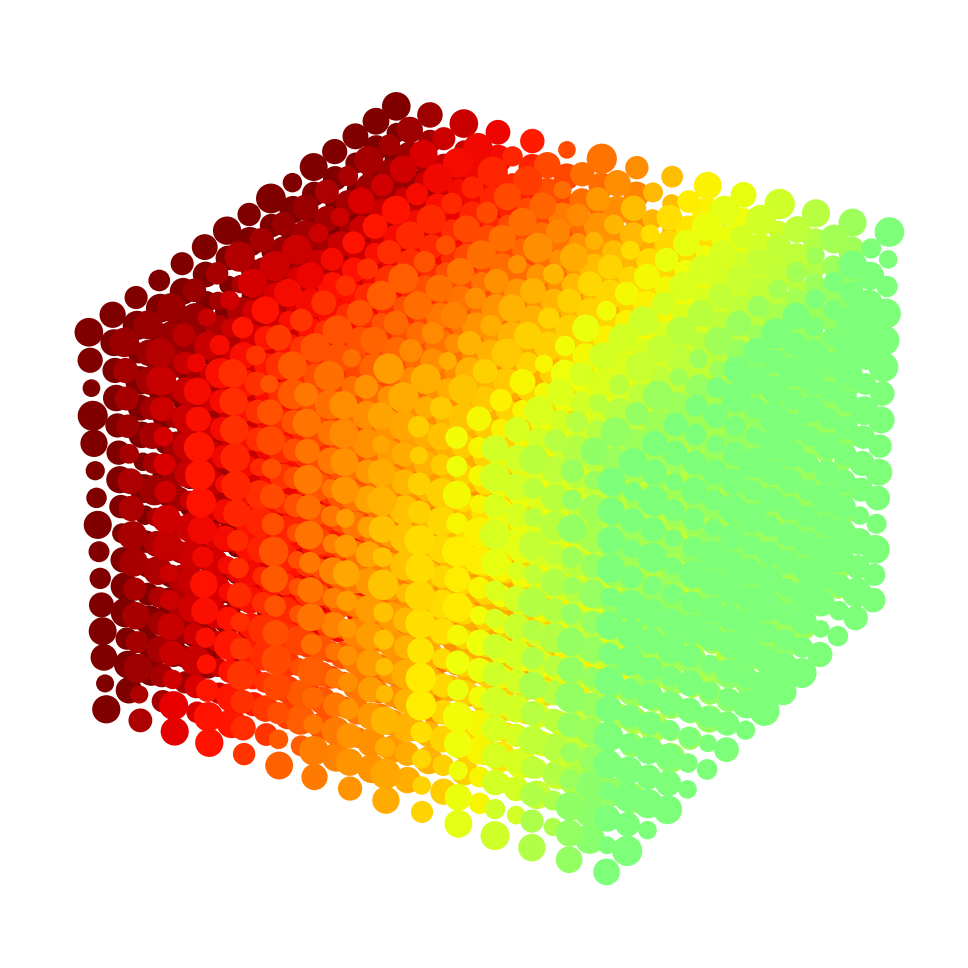

In [5]:
fig, ax = plt.subplots(figsize=[5, 5])
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.diameter"],
                                  color_by=Diff["pore.concentration"], 
                                  markersize=100)
_ = plt.axis('off')

## Calculate Formation Factor

In porous media research, the effective transport properties of one process can be used as a substitute for another, for example, electron conduction and diffusion are analogous.

$$
\frac{D_{eff}}{D_{AB}} = \frac{\sigma_{eff}}{\sigma}\\
$$

The formation factor can therefore be calculated from the ratio of the pure diffusion coefficient and the effective diffusion coefficient.

Note that the area and length of the domain can be determined using `get_domain_area` and `get_domain_length` respectively.  Please pay attention to the warnings that these may underestimate the size of the domain. Adding boundary pores to an extracted network will ensure the correct length is calculated.

In [6]:
# NBVAL_IGNORE_OUTPUT
R = Diff.rate(pores=inlet, mode='group')[0]
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet);
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
D_eff = R * L / (A) / (C_in - C_out)
F = 1/D_eff
print(f'Formation factor is: {F:.2f}')

[14:36:45] WARNING  Attempting to estimate inlet area...will be low        ]8;id=864654;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=774479;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1042\1042]8;;\

           WARNING  Attempting to estimate domain length...could be low if ]8;id=597947;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=608584;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1086\1086]8;;\
                    boundary pores were not added                                            

Formation factor is: 10089643222.09
